## Dados:

In [4]:
# Importe os dados necessários
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import os, shutil

In [ ]:
# Defina o estilo dos gráficos:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.)

#### Preparação dos dados

In [2]:
# Se necessário, instale o kagglehub:
!pip install -U pip
!pip install kagglehub

In [5]:
import kagglehub

def get_dataset_info(dataset: str, root='./data', target=None):
    db_types = ['game', 'book', 'anime', 'lastfm']
    assert dataset.lower() in db_types, f'Select one dataset from: {db_types}'
    if dataset == db_types[0]:
        # Steam VideoGame
        dataset = "tamber/steam-video-games"
        target  = os.path.join(root,
                               'steam-video-games'  if target is None else target)
    elif dataset == db_types[1]:
        # GoodBooks
        dataset = "arashnic/book-recommendation-dataset"
        target  = os.path.join(root,
                               'book-recommendation-dataset' if target is None else target)
    elif dataset == db_types[2]:
        # Anime
        dataset = "CooperUnion/anime-recommendations-database"
        target  = os.path.join(root,
                               'anime-recommendations-database' if target is None else target)
    elif dataset == db_types[3]:
        # LastFM dataset (music)
        dataset = "harshal19t/lastfm-dataset"
        target  = os.path.join(root,
                               'lastfm-dataset' if target is None else target)
    return dataset, root, target

# Defina seu dataset aqui:
DATASET = 'game'

KAGGLE_DATASET, ROOT_DATA_PATH, DATA_PATH = get_dataset_info(DATASET)
if os.path.isdir(DATA_PATH):
    print('Dataset já baixado!')
else:
    #kagglehub.login()
    path = kagglehub.dataset_download(handle=KAGGLE_DATASET)
    os.makedirs(ROOT_DATA_PATH, exist_ok=True)
    shutil.move(path, DATA_PATH)
    
print("Local dos arquivos:", DATA_PATH)
print("Arquivos:\n", os.listdir(DATA_PATH))

100%|████████████████████████████████████████████████████████████████| 1.46M/1.46M [00:00<00:00, 1.86MB/s]

Extracting files...
Local dos arquivos: ./data/steam-video-games
Arquivos:
 ['steam-200k.csv']


#### Análise dos dados

In [53]:
if DATASET == 'anime':
    # Anime:
    #==> anime-recommendations-database/rating.csv <==
    #user_id,anime_id,rating
    #1,20,-1
    ratings = pd.read_csv(os.path.join(DATA_PATH, 'rating.csv'))
    ratings = ratings[ratings['rating'] > 0]
    ratings.rename(columns={'anime_id':'item_id'}, inplace=True)
    ratings['rating'] = ratings['rating'].astype(float)
elif DATASET == 'book':
    # GoodBook
    #==> book-recommendation-dataset/Ratings.csv <==
    #User-ID,ISBN,Book-Rating
    #276725,034545104X,0
    books = pd.read_csv(os.path.join(DATA_PATH,'Books.csv'), low_memory=False)
    ratings = pd.read_csv(os.path.join(DATA_PATH, 'Ratings.csv'), low_memory=False)
    ratings = ratings.merge(books, on='ISBN')    
    ratings = ratings[ratings['Book-Rating'] > 0]
    POPULARITY_THRESHOLD = 50
    num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
    popular_books = num_rating_df[num_rating_df['Book-Rating'] >= POPULARITY_THRESHOLD]
    ratings = ratings[ratings['Book-Title'].isin(popular_books['Book-Title'])]
    ACTIVITY_THRESHOLD = 200
    user_activity_df = ratings_popular_books.groupby('User-ID').count()['Book-Rating'].reset_index()
    active_users = user_activity_df[user_activity_df['Book-Rating'] >= ACTIVITY_THRESHOLD]
    ratings = ratings[ratings['User-ID'].isin(active_users['User-ID'])]
    ratings.rename(columns={'User-ID':'user_id', 'ISBN':'item_id', 'Book-Rating':'rating'}, inplace=True)
    ratings = ratings[['user_id', 'item_id', 'rating']]
    ratings['rating'] = ratings['rating'].astype(float)
elif DATASET == 'game':
    # Steam Games
    #==> steam-video-games/steam-200k.csv <==
    #151603712,"The Elder Scrolls V Skyrim",purchase,1.0,0
    column_names = ['user_id', 'item_id', 'state', 'time', '0']
    ratings = pd.read_csv(os.path.join(DATA_PATH, 'steam-200k.csv'), names=column_names)
    ratings = ratings[ratings['state'] == 'play']
    #ratings = ratings[ratings['time'] > 0]
    # Usando o tempo para rating:
    ratings['min_time'] = ratings.groupby('user_id')['time'].transform('min')
    ratings['max_time'] = ratings.groupby('user_id')['time'].transform('max')
    ratings['rating'] = 10*(ratings['time'] - ratings['min_time'])/(ratings['max_time'] - ratings['min_time'])
    ratings = ratings[ratings['rating']>1.].round()
    ratings = ratings.drop(['state', 'time', '0', 'min_time', 'max_time'], axis='columns')
elif DATASET == 'lastfm':
    #==> lastfm-dataset/Last.fm_data.csv <==
    #,Username,Artist,Track,Album,Date,Time
    #0,Babs_05,Isobel Campbell,The Circus Is Leaving Town,Ballad of the Broken Seas,31 Jan 2021, 23:36
    #1,Babs_05,Isobel Campbell,Dusty Wreath,Ballad of the Broken Seas,31 Jan 2021, 23:32
    ratings = pd.read_csv(os.path.join(DATA_PATH, 'Last.fm_data.csv'), index_col=0)
    df_plays = ratings.groupby(['Username', 'Artist', 'Track']).size().reset_index(name='plays')
    df_plays = df_plays[df_plays['plays'] > 0]
    df_plays['min_plays'] = df_plays.groupby('Username')['plays'].transform('min')
    df_plays['max_plays'] = df_plays.groupby('Username')['plays'].transform('max')
    ratings['rating'] = (df_plays['plays'] - df_plays['min_plays'])/(df_plays['max_plays'] - df_plays['min_plays'])
    ratings = ratings[ratings['rating'] > 0]
    ratings['rating'] = ratings['rating'] * 10
    ratings.rename(columns={'Username': 'user_id', 'Track': 'item_id'}, inplace=True)
    ratings = ratings[['user_id', 'item_id', 'rating']]
else:
    print("Seu DATASET está errado!!!!")

ratings.head(10)

,user_id,item_id,rating
1,151603712,The Elder Scrolls V Skyrim,10.0
3,151603712,Fallout 4,3.0
69,59945701,Ultra Street Fighter IV,10.0
71,59945701,FINAL FANTASY XIII,4.0
73,59945701,The Elder Scrolls V Skyrim,2.0
134,53875128,Grand Theft Auto V,10.0
136,53875128,Insurgency,8.0
138,53875128,Left 4 Dead 2,8.0
140,53875128,METAL GEAR SOLID V THE PHANTOM PAIN,7.0
142,53875128,S.T.A.L.K.E.R. Shadow of Chernobyl,6.0


In [7]:

ratings['rating']

1         10.0
3          3.0
5          1.0
7          0.0
9          0.0
          ... 
199991     0.0
199993     0.0
199995     0.0
199997     0.0
199999     0.0
Name: rating, Length: 70489, dtype: float64


Estatísticas descritivas das avaliações:
count    63892.000000
mean         1.360155
std          2.864322
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: rating, dtype: float64


<Axes: ylabel='rating'>

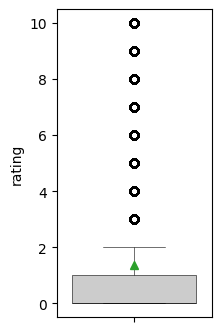

In [8]:
print("\nEstatísticas descritivas das avaliações:")
print(ratings['rating'].describe())
plt.figure(figsize=(2,4))
sns.boxplot(data=ratings, y='rating', color='.8', linecolor="#000", linewidth=0.4, showmeans=True)

In [51]:
def set_title_and_axes(title, xlabel, ylabel):
    # Analisando o número de avaliações por usuário
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

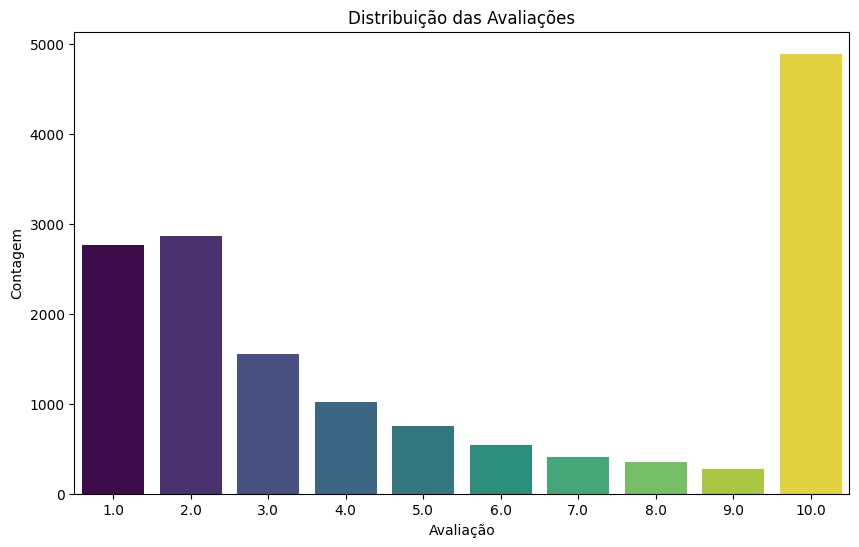

In [54]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', hue='rating', data=ratings, palette='viridis', legend=False)
set_title_and_axes('Distribuição das Avaliações', 'Avaliação', 'Contagem')

In [56]:
# Analisando o número de avaliações por usuário
ratings_per_user = ratings.groupby('user_id').size()
ratings_per_user

user_id
5250         2
76767        5
86540        5
181212       1
229911       4
            ..
308760273    1
309052991    1
309188905    1
309265377    1
309404240    3
Length: 4772, dtype: int64

In [57]:
from collections import Counter
#print('\n'.join(f'Usuário {u:3d}: {v:3d} votos' for u,v in Counter(ratings['user_id']).most_common(10)))
for u,v in Counter(ratings['user_id']).most_common(10):
    print(f'Usuário {u:3d}: {v:3d} votos')

Usuário 24469287:  54 votos
Usuário 51557405:  50 votos
Usuário 17530772:  46 votos
Usuário 86469479:  45 votos
Usuário 58345543:  44 votos
Usuário 53875128:  42 votos
Usuário 65958466:  40 votos
Usuário 1936551:  39 votos
Usuário 101690993:  35 votos
Usuário 11970504:  35 votos


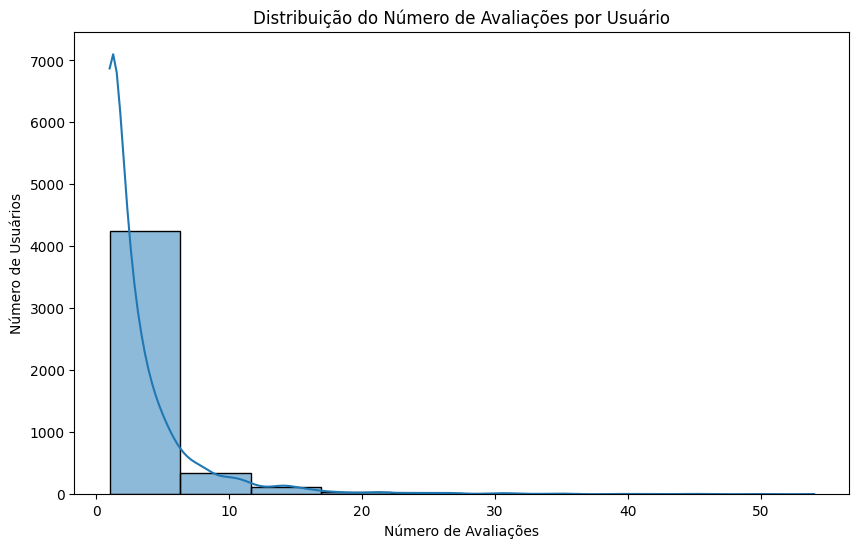

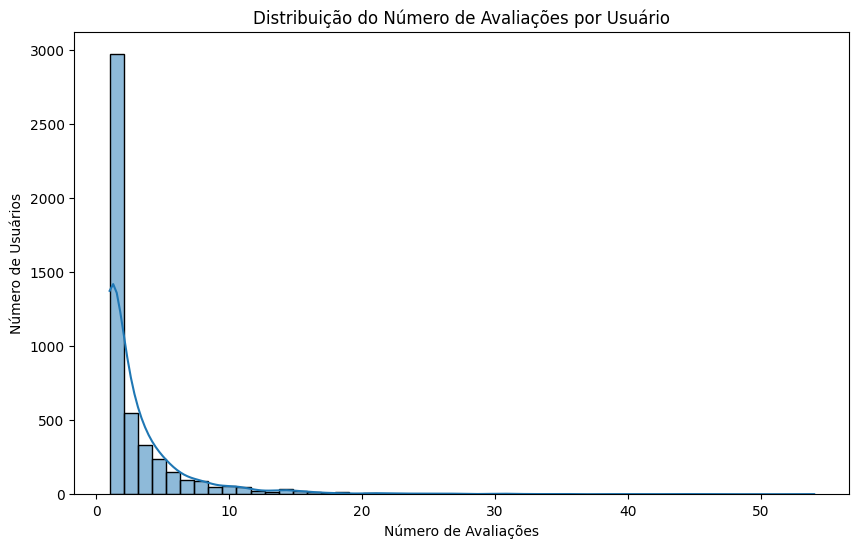

In [58]:
# Exibindo os dados em um histograma com 10 e com 50 barras (bins):
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=10, kde=True)
set_title_and_axes('Distribuição do Número de Avaliações por Usuário',
                   'Número de Avaliações','Número de Usuários')
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=50, kde=True)
set_title_and_axes('Distribuição do Número de Avaliações por Usuário',
                   'Número de Avaliações', 'Número de Usuários')

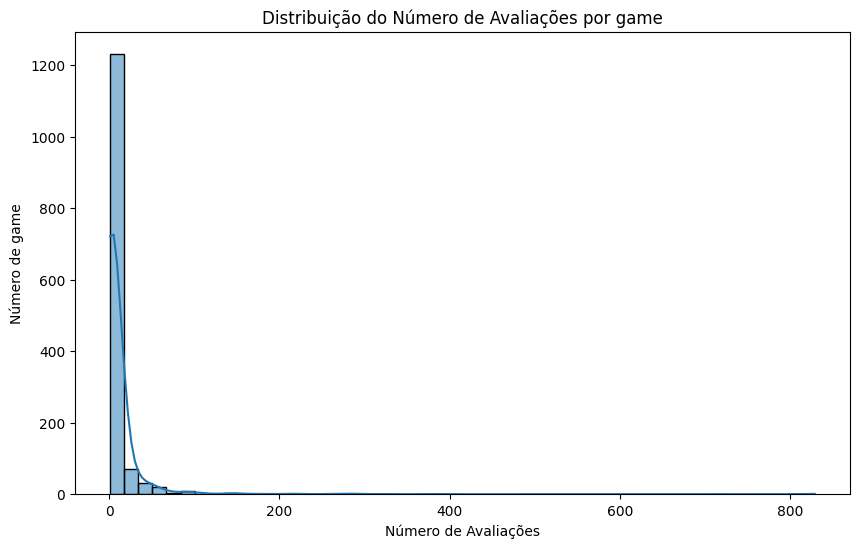

In [61]:
# Analisando o número de avaliações por item
ratings_per_movie = ratings.groupby('item_id').size()
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
set_title_and_axes(f'Distribuição do Número de Avaliações por {DATASET}',
                   'Número de Avaliações', f'Número de {DATASET}')

In [62]:
# Preparação dos dados para o modelo
# Criando uma matriz de usuários x filmes
user_item_matrix = ratings.pivot_table(
    index='user_id', 
    columns='item_id', 
    values='rating',
    aggfunc='mean',   # Define como lidar com duplicatas (aqui, tiramos a média)
    fill_value=0      # Preenche os valores ausentes com 0
)
user_item_matrix.head()

item_id,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),100% Orange Juice,12 Labours of Hercules II The Cretan Bull,3DMark,3DMark Vantage,4 Elements,7 Days to Die,8BitMMO,A New Beginning - Final Cut,A Story About My Uncle,...,Zombies Monsters Robots,Zuma's Revenge,iBomber Defense Pacific,ibb & obb,liteCam Game 100 FPS Game Capture,resident evil 4 / biohazard 4,sZone-Online,the static speaks my name,theHunter,theHunter Primal
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# Convertendo para matriz esparsa
user_item_sparse = csr_matrix(user_item_matrix.values)

In [64]:
# Criando mapeamento de IDs para índices contínuos (0 a n-1)
user_id_map = {id: i for i, id in enumerate(ratings['user_id'].unique())}
item_id_map = {id: i for i, id in enumerate(ratings['item_id'].unique())}
'''Para quem tem dúvidas com Python, foi feito o seguinte:
user_id_map = {}
i = 0
for id in ratings['user_id'].unique():
    user_id_map[id] = i
    i+=1
'''
first_item = list(user_id_map.items())[0]
print(f'Usuário "{first_item[0]}" mapeado para "{first_item[1]}"')

Usuário "151603712" mapeado para "0"


In [65]:
list(user_id_map.items())[:10]

[(np.int64(151603712), 0),
 (np.int64(59945701), 1),
 (np.int64(53875128), 2),
 (np.int64(26122540), 3),
 (np.int64(297811211), 4),
 (np.int64(218323237), 5),
 (np.int64(126340495), 6),
 (np.int64(194895541), 7),
 (np.int64(97298878), 8),
 (np.int64(173909336), 9)]

In [66]:
# Aplicando o mapeamento
ratings['user_idx'] = ratings['user_id'].map(user_id_map)
ratings['item_idx'] = ratings['item_id'].map(item_id_map)
print('Note as novas colunas: "user_idx" e "item_idx"')
ratings

Note as novas colunas: "user_idx" e "item_idx"


,user_id,item_id,rating,user_idx,item_idx
1,151603712,The Elder Scrolls V Skyrim,10.0,0,0
3,151603712,Fallout 4,3.0,0,1
69,59945701,Ultra Street Fighter IV,10.0,1,2
71,59945701,FINAL FANTASY XIII,4.0,1,3
73,59945701,The Elder Scrolls V Skyrim,2.0,1,0
...,...,...,...,...,...
199961,221315846,Dota 2,10.0,4770,52
199963,221315846,Team Fortress 2,6.0,4770,51
199965,221315846,Tom Clancy's Ghost Recon Phantoms - EU,3.0,4770,260
199969,128470551,The Binding of Isaac Rebirth,10.0,4771,263


In [67]:
# Dividindo os dados em treino e teste (80% treino, 20% teste)
# valor usar o stratify para organizar a mesma quantidade de ratings em cada subconjunto:
ratings = ratings.dropna(subset=['rating'])
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings['rating'])

In [68]:
train_data.describe()

,user_id,rating,user_idx,item_idx
count,1.234100e+04,12341.000000,12341.000000,12341.000000
mean,1.126693e+08,5.271615,2349.006726,234.747832
std,7.213688e+07,3.672840,1391.279793,272.329439
min,5.250000e+03,1.000000,0.000000,0.000000
25%,5.625699e+07,2.000000,1133.000000,52.000000
50%,9.917116e+07,4.000000,2368.000000,127.000000
75%,1.631148e+08,10.000000,3541.000000,308.000000
max,3.094042e+08,10.000000,4771.000000,1385.000000


In [69]:
test_data.describe()

,user_id,rating,user_idx,item_idx
count,3.086000e+03,3086.000000,3086.000000,3086.000000
mean,1.116106e+08,5.271873,2353.959170,235.654245
std,7.213928e+07,3.673061,1379.604408,275.573276
min,8.654000e+04,1.000000,0.000000,0.000000
25%,5.458565e+07,2.000000,1171.000000,52.000000
50%,9.909406e+07,4.000000,2370.500000,127.000000
75%,1.632514e+08,10.000000,3535.000000,307.750000
max,3.094042e+08,10.000000,4767.000000,1381.000000


In [70]:
# Salvando os dados processados para uso posterior
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
# Salvando os mapeamentos
np.save('user_id_map.npy', user_id_map)
np.save('item_id_map.npy', item_id_map)

## Rede Neural

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [71]:
# Verificando se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [72]:
# Carregando os dados processados
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Carregando os mapeamentos
user_id_map = np.load('user_id_map.npy', allow_pickle=True).item()
item_id_map = np.load('item_id_map.npy', allow_pickle=True).item()

In [73]:
# Obtendo o número de usuários e itens
num_users = len(user_id_map)
num_items = len(item_id_map)
print(f"Número de usuários: {num_users}")
print(f"Número de itens: {num_items}")

Número de usuários: 4772
Número de itens: 1386


In [74]:
# Definindo o dataset personalizado. Porém, mais rápido:
class MyDataset(Dataset):
    def __init__(self, ratings_df):
        self.user = torch.tensor(ratings_df['user_idx'].to_numpy(), dtype=torch.long)
        self.item = torch.tensor(ratings_df['item_idx'].to_numpy(), dtype=torch.long)
        self.rating = torch.tensor(ratings_df['rating'].to_numpy(), dtype=torch.float)
        # if self.rating.max().item() == 5:
            # self.rating -= 1
        
    def __len__(self):
        return len(self.user)

    def __getitem__(self, idx):        
        return {
            'user': self.user[idx],
            'item': self.item[idx],
            'rating': self.rating[idx]
        }

    def device(self, device):
        self.user = self.user.to(device)
        self.item = self.item.to(device)
        self.rating = self.rating.to(device)
        
    def cuda(self):
        self.device('cuda')

    def cpu(self):
        self.device('cpu')

In [75]:
# Criando os datasets
train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)

In [76]:
# Movendo entre as memórias da CPU e da GPU
if str(device) == 'cuda':
    # só roda se essa máquina tem CUDA
    train_dataset.cuda()
    print(train_dataset[0])
train_dataset.cpu()
print(train_dataset[0])

{'user': tensor(2616, device='cuda:0'), 'item': tensor(120, device='cuda:0'), 'rating': tensor(2., device='cuda:0')}
{'user': tensor(2616), 'item': tensor(120), 'rating': tensor(2.)}


In [90]:
# Criando o data loader
batch_size = 32
train_dataset.device(device)
test_dataset.device(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [91]:
for d in train_loader:
    print('user:', d['user'][0])
    print('video:', d['item'][0])
    print('rating:', d['rating'][0])
    break

user: tensor(1338, device='cuda:0')
video: tensor(787, device='cuda:0')
rating: tensor(3., device='cuda:0')


In [92]:
# Definindo o modelo Neural Collaborative Filtering (NCF)
class NCF(nn.Module):
    """
    Neural Collaborative Filtering (NCF)
    
    Implementa um modelo híbrido que combina:
    1. Filtragem colaborativa baseada em matriz de fatores (MF)
    2. Redes neurais multicamadas (MLP)
    """
    def __init__(self, num_users, num_items, embedding_size=50, mlp_layers=[100, 50], dropout=0.2):
        super(NCF, self).__init__()
        
        # Camada de embedding para usuários e itens (parte MF (Matrix Fatorization)
        self.user_embedding_mf = nn.Embedding(num_users, embedding_size)
        self.item_embedding_mf = nn.Embedding(num_items, embedding_size)
        
        # Camada de embedding para usuários e itens (parte MLP (Multi-Layer Perceptron))
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_size)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_size)
        
        # Camadas MLP
        self.mlp_layers = nn.ModuleList()
        input_size = 2 * embedding_size  # Concatenação dos embeddings de usuário e item
        
        # Construindo as camadas MLP
        for i, layer_size in enumerate(mlp_layers):
            if i == 0:
                self.mlp_layers.append(nn.Linear(input_size, layer_size))
            else:
                self.mlp_layers.append(nn.Linear(mlp_layers[i-1], layer_size))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(dropout))
        
        # Camada de saída que combina MF e MLP
        self.output_layer = nn.Linear(embedding_size + mlp_layers[-1], 1)
        
        # Inicialização dos pesos
        self._init_weights()
    
    def _init_weights(self):
        """Inicializa os pesos do modelo usando a distribuição normal."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
    
    def forward(self, user_indices, item_indices):
        # Embeddings para parte MF
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_vector = user_embedding_mf * item_embedding_mf  # Produto elemento a elemento
        
        # Embeddings para parte MLP
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        
        # Passando pela rede MLP
        for layer in self.mlp_layers:
            mlp_vector = layer(mlp_vector)
        
        # Concatenando os resultados de MF e MLP
        vector = torch.cat([mf_vector, mlp_vector], dim=-1)
        
        # Camada de saída
        rating = self.output_layer(vector)
        
        return rating.squeeze()

In [93]:
from torch.nn import functional as F
# Função para treinar o modelo por uma época
def train_model(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    
    for batch in train_loader:
        user = batch['user'].to(device)
        item = batch['item'].to(device)
        rating = batch['rating'].to(device)
        # rating = F.one_hot(rating, num_classes=5).type(torch.float)
        
        # Zerando os gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(user, item)
        loss = criterion(outputs, rating)
        
        # Backward pass e otimização
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * user.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_time = time.time() - start_time
    
    print(f"Época {epoch+1} - Perda Treino: {epoch_loss:.4f} - Tempo: {epoch_time:.2f}s")
    
    return epoch_loss

In [112]:
# Função para avaliar o modelo
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    pred, y = [],[]
    with torch.no_grad():
        for batch in test_loader:
            user = batch['user'] .to(device)
            item = batch['item'] .to(device)
            rating = batch['rating'] .to(device)
            # rating = F.one_hot(rating, num_classes=5).type(torch.float)
            
            outputs = model(user, item)
            loss = criterion(outputs, rating)
            pred.append(outputs.cpu().detach().tolist())
            y.append(rating.cpu().detach().tolist())
            running_loss += loss.item() * user.size(0)
    
    test_loss = running_loss / len(test_loader.dataset)
    print(f"Perda Teste: {test_loss:.4f}")
    
    return test_loss, pred, y

In [113]:
_, pred, y = evaluate_model(model, test_loader, criterion, device)

Perda Teste: 12.6940


In [120]:
pred_ = np.concatenate(pred)
y_ = np.concatenate(y)

In [130]:
# verifica erros entr
np.sum(np.abs(pred_.round() - y_) < 4)

np.int64(1945)

In [97]:
# Criando o modelo
embedding_size = 64
mlp_layers = [128, 64, 32, 16]
model = NCF(num_users, num_items, embedding_size, mlp_layers)
model = model.to(device)

# Definindo a função de perda e o otimizador
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

# Treinando o modelo
num_epochs = 32
train_losses = []
test_losses = []

print("Iniciando treinamento...")
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device, epoch)
    test_loss = evaluate_model(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Salvando o modelo treinado
torch.save(model.state_dict(), 'modelo_ncf.pth')
print("Modelo salvo como 'modelo_ncf.pth'")

Iniciando treinamento...
Época 1 - Perda Treino: 41.2575 - Tempo: 0.54s
Perda Teste: 41.2365
Época 2 - Perda Treino: 41.2092 - Tempo: 0.53s
Perda Teste: 41.1792
Época 3 - Perda Treino: 41.1251 - Tempo: 0.51s
Perda Teste: 41.0486
Época 4 - Perda Treino: 40.8764 - Tempo: 0.51s
Perda Teste: 40.6241
Época 5 - Perda Treino: 40.0943 - Tempo: 0.52s
Perda Teste: 39.3631
Época 6 - Perda Treino: 38.0625 - Tempo: 0.52s
Perda Teste: 36.4543
Época 7 - Perda Treino: 34.0180 - Tempo: 0.51s
Perda Teste: 31.3025
Época 8 - Perda Treino: 27.9038 - Tempo: 0.53s
Perda Teste: 24.5058
Época 9 - Perda Treino: 21.1235 - Tempo: 0.51s
Perda Teste: 18.2186
Época 10 - Perda Treino: 16.3760 - Tempo: 0.53s
Perda Teste: 14.7193
Época 11 - Perda Treino: 14.6695 - Tempo: 0.51s
Perda Teste: 13.6203
Época 12 - Perda Treino: 14.0288 - Tempo: 0.53s
Perda Teste: 13.2924
Época 13 - Perda Treino: 13.7482 - Tempo: 0.52s
Perda Teste: 13.1436
Época 14 - Perda Treino: 13.6187 - Tempo: 0.51s
Perda Teste: 13.0340
Época 15 - Perda T

(<matplotlib.legend.Legend at 0x7fb4f6a1fa10>, None)

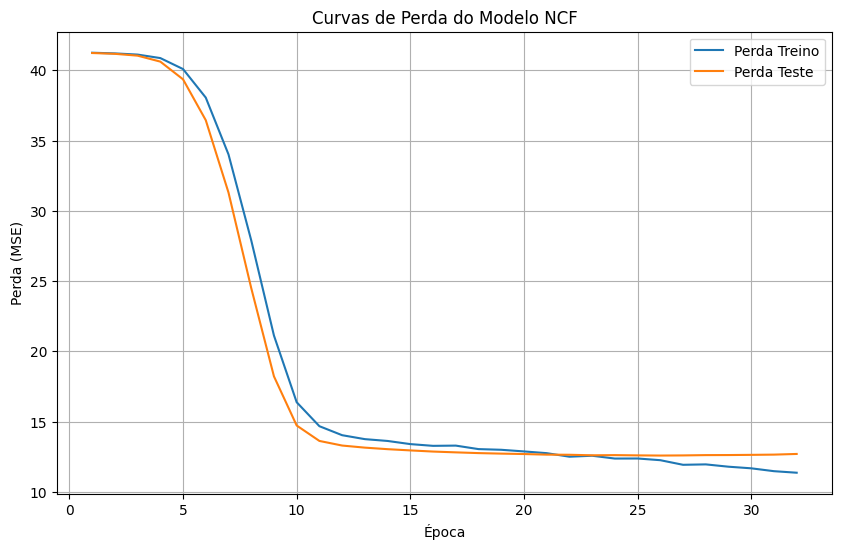

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Perda Treino')
plt.plot(range(1, num_epochs+1), test_losses, label='Perda Teste')
set_title_and_axes('Curvas de Perda do Modelo NCF', 'Época', 'Perda (MSE)')
plt.legend(), plt.grid(True)

In [ ]:
# Função para recomendar filmes para um usuário
def recommend_movies(model, user_id, ratings_df, user_id_map, item_id_map, movies_df, top_n=10):
    model.eval()
    
    # Obtendo o índice do usuário
    user_idx = user_id_map[user_id]
    
    # Filmes já avaliados pelo usuário
    user_rated_items = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'].values)
    
    # Filmes não avaliados pelo usuário
    all_items = set(ratings_df['item_id'].unique())
    unrated_items = list(all_items - user_rated_items)
    
    # Convertendo para índices
    unrated_items_idx = [item_id_map[item] for item in unrated_items]
    
    # Preparando os dados para predição
    user_tensor = torch.tensor([user_idx] * len(unrated_items_idx), dtype=torch.long).to(device)
    item_tensor = torch.tensor(unrated_items_idx, dtype=torch.long).to(device)
    
    # Fazendo a predição
    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).argmax(1)+1
    
    # Obtendo os top-n filmes recomendados
    _, indices = torch.topk(predictions, top_n)
    recommended_item_idx = [unrated_items_idx[idx] for idx in indices.cpu().numpy()]
    
    # Convertendo de volta para os IDs originais
    reverse_item_map = {v: k for k, v in item_id_map.items()}
    recommended_items = [reverse_item_map[idx] for idx in recommended_item_idx]
    
    # Obtendo os títulos dos filmes
    recommended_titles = []
    for item_id in recommended_items:
        title = movies_df[movies_df['movie_id'] == item_id]['title'].values[0]
        recommended_titles.append(title)
    
    return recommended_items, recommended_titles

# Carregando informações dos filmes para exibir os títulos
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 
                 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                 'Sci-Fi', 'Thriller', 'War', 'Western']
all_columns = movie_columns + genre_columns

movies = pd.read_csv(path.join(DATA_PATH, 'u.item'), sep='|', names=all_columns, encoding='ISO-8859-1')

# Exemplo de recomendação para alguns usuários
test_users = [1, 100, 300, 500]
for user_id in test_users:
    _, recommended_titles = recommend_movies(model, user_id, ratings, user_id_map, item_id_map, movies, top_n=5)
    
    print(f"\nRecomendações para o usuário {user_id}:")
    for i, title in enumerate(recommended_titles):
        print(f"{i+1}. {title}")

## Avaliação do sistema

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Fazendo previsões no conjunto de teste
user_indices = torch.tensor(test_data['user_idx'].values, dtype=torch.long).to(device)
item_indices = torch.tensor(test_data['item_idx'].values, dtype=torch.long).to(device)
actual_ratings = test_data['rating'].values

with torch.no_grad():
    predicted_ratings = model(user_indices, item_indices).cpu().argmax(1).numpy()+1

# Calculando métricas de erro
rmse = sqrt(mean_squared_error(actual_ratings, predicted_ratings))
mae = mean_absolute_error(actual_ratings, predicted_ratings)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Análise da distribuição de erros
errors = np.abs(actual_ratings - predicted_ratings)

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=5, kde=True)
set_title_and_axes('Distribuição dos Erros de Previsão',
                   'Erro (Avaliação Real - Avaliação Prevista)','Frequência')

In [ ]:
# Comparação entre avaliações reais e previstas
plt.figure(figsize=(10, 8))
noise = np.random.randn(predicted_ratings.shape[0])/10 #-0.1, ..., 0.1
#plt.scatter(actual_ratings, predicted_ratings+noise, alpha=0.1)
sns.catplot(x=actual_ratings, y=predicted_ratings, kind="violin")
plt.plot([0, 5], [1, 6], 'r--')
#plt.xlim(0.5, 5.5), plt.ylim(0.5, 5.5)
plt.xlim(0.2, 5.), plt.ylim(0.2, 5.5)
set_title_and_axes('Avaliações Reais vs. Previstas',
                   'Avaliação Real', 'Avaliação Prevista')
print((actual_ratings == predicted_ratings).sum()/len(actual_ratings))
print((actual_ratings-1 == predicted_ratings).sum()/len(actual_ratings))
print((actual_ratings+1 == predicted_ratings).sum()/len(actual_ratings))

Erro médio quadrático:\
$\frac{\sum_{i=1}^{n}{(y_i - \hat{y}_i)^2}}{n}$

In [ ]:
np.sum((actual_ratings - predicted_ratings)**2)/len(actual_ratings)

In [ ]:
# Boxplot das previsões agrupadas por avaliação real
df_results = pd.DataFrame({
    'actual': actual_ratings,
    'predicted': predicted_ratings
})

plt.figure(figsize=(12, 8))
sns.boxplot(x='actual', y='predicted', data=df_results)
set_title_and_axes('Boxplot das Previsões por Avaliação Real',
                   'Avaliação Real', 'Avaliação Prevista')

In [ ]:
# Calculando precisão para diferentes limiares
thresholds = [3.0, 3.5, 4.0, 4.5]
precision_values = []

for threshold in thresholds:
    # Itens recomendados (previsão >= threshold)
    recommended = predicted_ratings >= threshold
    # Itens relevantes (avaliação real >= threshold)
    relevant = actual_ratings >= threshold
    # Itens recomendados que são relevantes
    true_positives = np.logical_and(recommended, relevant).sum()
    # Precisão: proporção de recomendações corretas
    precision = true_positives / recommended.sum() if recommended.sum() > 0 else 0
    precision_values.append(precision)
    print(f"Precisão para limiar {threshold}: {precision:.4f}")